In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

In [3]:
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=2)]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

print(y)

tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1])


In [4]:
epsilon=.06

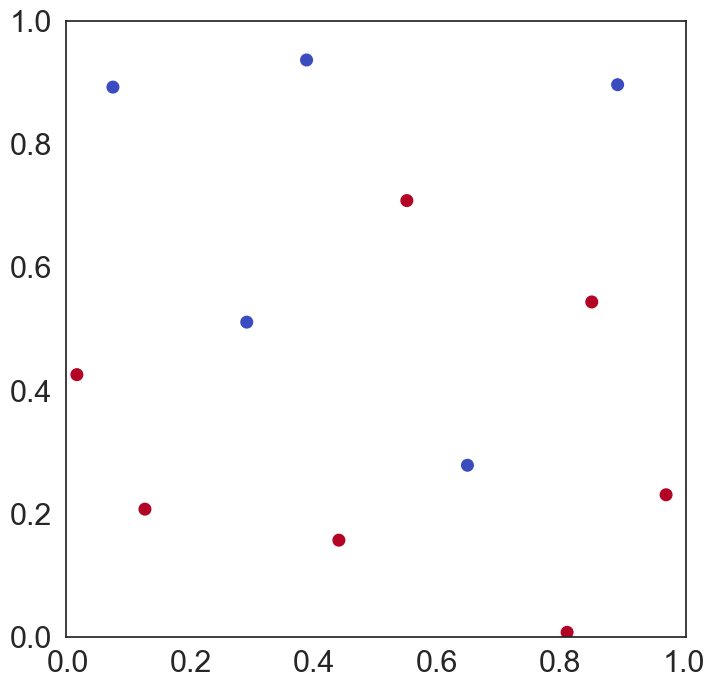

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])
plt.show()

In [6]:
def net_with_eps(net, mu, eps):
  mu, eps = mu.T, eps.T
  for i,layer in enumerate(net):
    if isinstance(layer, nn.Linear):
      mu = layer._parameters["weight"] @ mu + layer._parameters["bias"][:,None]
      eps = torch.abs(layer._parameters["weight"]) @ eps
      # print(i, "\n mu:", mu , " '\n eps: ", eps)
    elif isinstance(layer, nn.ReLU):
      z_l, z_u = mu - eps, mu + eps
      z_l, z_u = F.relu(z_l), F.relu(z_u)
      mu, eps = (z_u + z_l) / 2, (z_u - z_l) / 2
    else:
      raise NotImplemented
  mu, eps = mu.T, eps.T
  return mu-eps, mu+eps, mu, eps

In [7]:
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

N = 20000
NN = 10000
for i in range(N):
    if i < NN:
      eps = (i/(NN-1))*epsilon*torch.ones_like(X)
    # eps = epsilon*torch.ones_like(X)
    z_l, z_u, mu_pred, eps_pred = net_with_eps(net, Variable(X), Variable(eps, requires_grad=False))
    loss_fit = criterion(mu_pred, y)

    # z = z_u
    # z[y.long()] = z_l
    tmp = nn.functional.one_hot(y, mu_pred.size(-1))
    z = torch.where(tmp.bool(), z_l, z_u)

    loss_spec = criterion(z,y)
    if i < NN:
      kappa = max(1 - 0.00005*i, 0.5)

    loss = kappa * loss_fit + (1-kappa) * loss_spec
    err = (mu_pred.argmax(dim=1) != y).float().sum()
    worst_case_err = (z.argmax(dim=1) != y).float().sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
      if i % 1000 == 0:
          print(loss.data.item(), err.item(), worst_case_err.item())

print(loss.data.item(), err.item(), worst_case_err.item())
print(eps)

print (tmp)

0.6937198638916016 7.0 7.0
3.0961429729359224e-05 0.0 0.0
1.8640648704604246e-05 0.0 0.0
6.396317530743545e-06 0.0 0.0
2.9166128570068395e-06 0.0 0.0
1.5323265643019113e-06 0.0 0.0
7.659171501472883e-07 0.0 0.0
3.859395860672521e-07 0.0 0.0
2.463657153839449e-07 0.0 0.0
1.9222487424030987e-07 0.0 0.0
8.443145560477205e-08 0.0 0.0
9.933112998794513e-09 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
tensor([[0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600],
        [0.0600, 0.0600]])
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]])


/Users/kacpermarzol/miniconda3/envs/AILAB/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


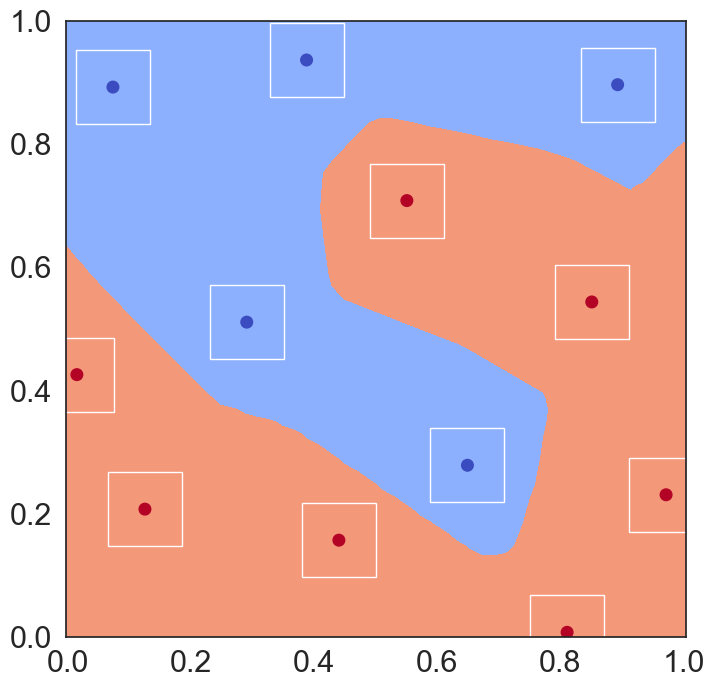

In [8]:
with torch.no_grad():
  XX, YY = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
  X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
  eps_temp = 0.0
  eps0 = eps_temp*torch.ones_like(X0)

  s1, s2, y0, s3 = net_with_eps(net, Variable(X0), Variable(eps0))
  # print("\n s1:", s1, '\n s2:', s2, '\n s3: ', s3 , '\n y0:' , y0)
  ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()
  fig, ax = plt.subplots(figsize=(8,8))
  ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
  ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
  ax.axis("equal")
  ax.axis([-0,1,-0,1])

  for a in x:
      ax.add_patch(patches.Rectangle((a[0]-epsilon, a[1]-epsilon), 2*epsilon, 2*epsilon, fill=False))

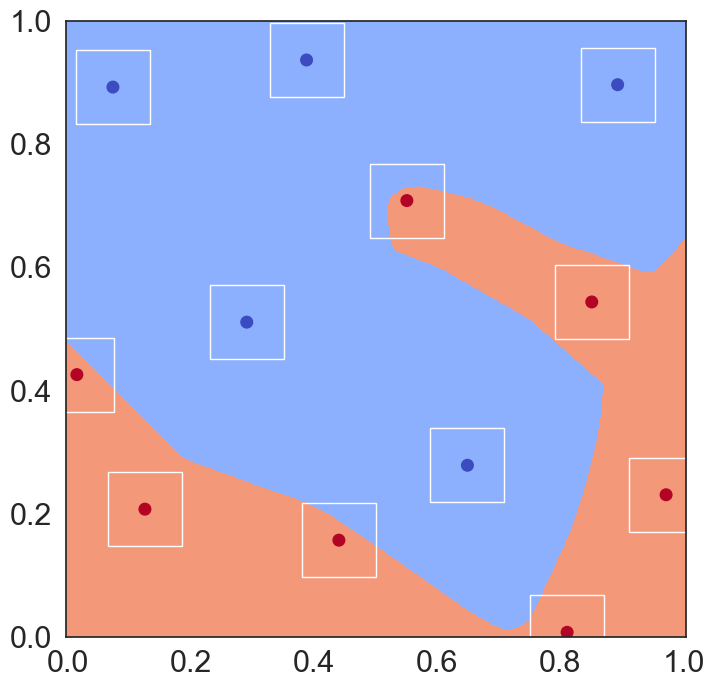

In [9]:
with torch.no_grad():
  XX, YY = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
  X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
  eps_temp = epsilon
  eps0 = eps_temp*torch.ones_like(X0)
  # eps0 = epsilon*torch.ones_like(X0)
  _, _, y0, _ = net_with_eps(net, Variable(X0), Variable(eps0))
  ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

  fig, ax = plt.subplots(figsize=(8,8))
  ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
  ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
  ax.axis("equal")
  ax.axis([-0,1,-0,1])

  for a in x:
      ax.add_patch(patches.Rectangle((a[0]-epsilon, a[1]-epsilon), 2*epsilon, 2*epsilon, fill=False))

_______

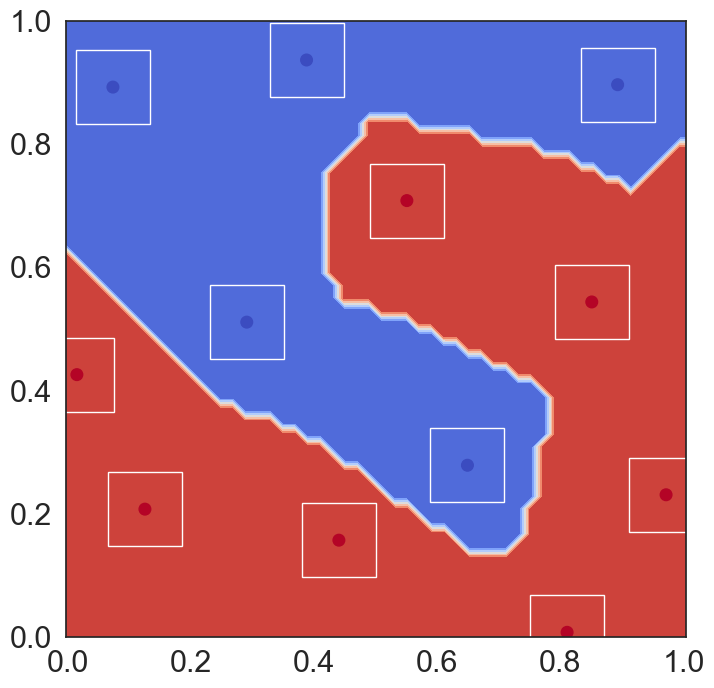

In [10]:
with torch.no_grad():
  XX, YY = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
  X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
  eps_temp = 0.0
  eps0 = eps_temp*torch.ones_like(X0)

###################
  # x1=np.array([[0.4,0.2]])
  # X1 = Variable(torch.Tensor(x1))
  # eps1 = eps_temp*torch.ones_like(X1)
  # s1, s2, y1, s3 = net_with_eps(net, Variable(X1), Variable(eps1))
  # y1 = torch.sigmoid(y1)
  # y1=torch.where(y1>0.5, 1,0)
  # print(y1)
###################

  s1, s2, y0, s3 = net_with_eps(net, Variable(X0), Variable(eps0))

  y0 = torch.sigmoid(y0)
  y0=torch.where(y0>0.5, 1,0)
  ZZ = (torch.argmax(y0, dim=1)).resize(100,100).data.numpy()

  fig, ax = plt.subplots(figsize=(8,8))
  ax.contourf(XX,YY,ZZ, cmap="coolwarm")
  ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
  ax.axis("equal")
  ax.axis([-0,1,-0,1])

  for a in x:
      ax.add_patch(patches.Rectangle((a[0]-epsilon, a[1]-epsilon), 2*epsilon, 2*epsilon, fill=False))

____

# Regresja

## bez epsilona

In [11]:
net2 = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,1)
)

opt2 = optim.Adam(net2.parameters(), lr=1e-3)
criterion2 = nn.MSELoss()

N = 20000
NN = 10000
y1=y.float()
for i in range(N):
    eps = 0*torch.ones_like(X)
    z_l, z_u, mu_pred, eps_pred = net_with_eps(net2, Variable(X), Variable(eps, requires_grad=False))

    mu_pred_tmp=mu_pred.reshape(y1.shape)
    loss = criterion2(mu_pred_tmp, y1)

    opt2.zero_grad()
    loss.backward()
    opt2.step()
    with torch.no_grad():

      if i % 1000 == 0:
          print(loss.data.item())
      if i == 20000-1:
          print(mu_pred)


print(loss.data.item(), err.item(), worst_case_err.item())


0.5190106630325317
9.529413941768866e-16
3.316725713520263e-11
4.528784895788942e-15
1.2027416541268856e-16
4.625929407134921e-18
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]], grad_fn=<PermuteBackward0>)
0.0 0.0 0.0


In [12]:
def custom_activation(x):
    condition1 = (x > 0.9)
    condition2 = (x <= 1.0)
    condition3 = (x >= 0.0)
    condition4 = (x < 0.1)

    output = torch.where(condition1 & condition2, torch.ones_like(x), x)
    output = torch.where(condition3 & condition4, torch.zeros_like(x), output)

    return output


tensor([[ 4.9813],
        [ 4.9313],
        [ 4.8813],
        ...,
        [-0.4346],
        [-0.4375],
        [-0.4404]]) 



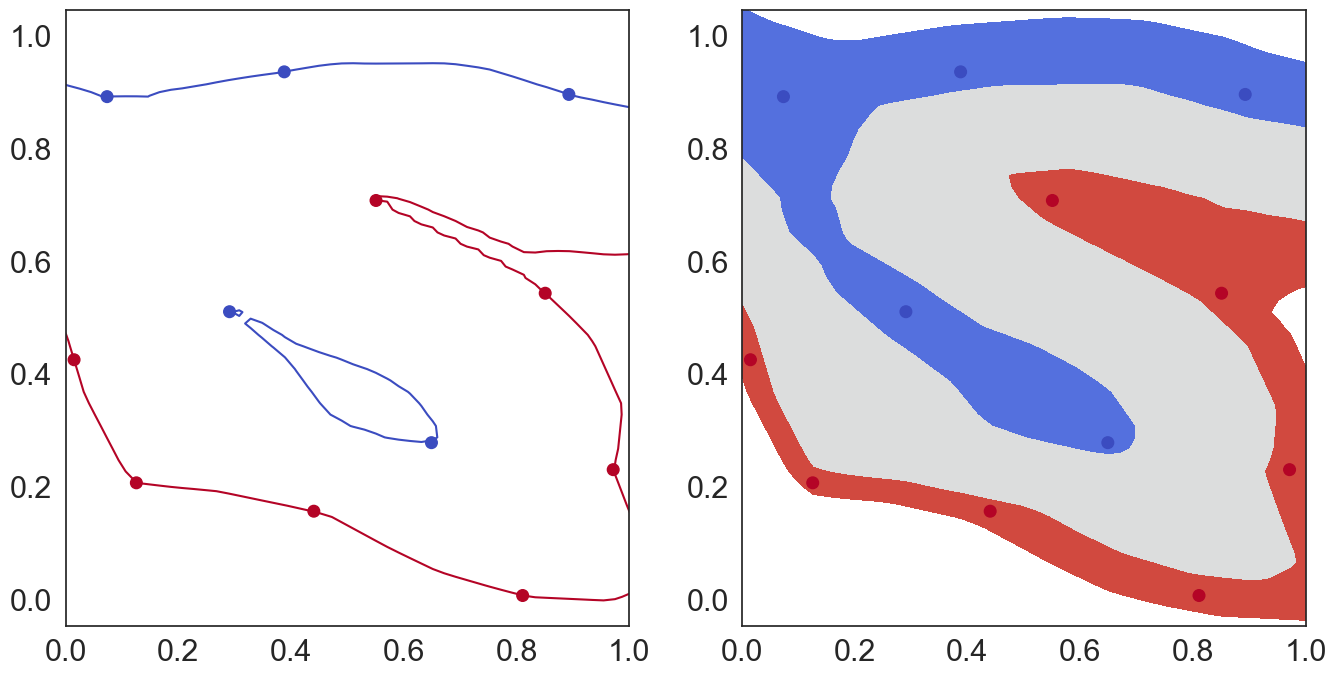

In [13]:
with torch.no_grad():
  XX, YY = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
  X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
  eps_temp = 0.0
  eps0 = eps_temp*torch.ones_like(X0)

  s1, s2, y0, s3 = net_with_eps(net2, Variable(X0), Variable(eps0))
  print(y0, '\n')
  ZZ = (y0).resize(100,100).data.numpy()

  fig, ax = plt.subplots(1,2, figsize=(16,8))
  ax[0].contour(XX,YY,ZZ, levels=[0,1], cmap='coolwarm')
  ax[0].scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
  ax[0].axis("equal")
  ax[0].axis([-0,1,-0,1])

  # y0=custom_activation(y0)
  # ZZ = (y0).resize(100,100).data.numpy()
  ax[1].contourf(XX,YY,ZZ, levels=[-0.1,0.1,0.9,1.1], cmap='coolwarm')
  ax[1].scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
  ax[1].axis("equal")
  ax[1].axis([-0,1,-0,1])

  #
  # for a in x:
  #     ax[0].add_patch(patches.Rectangle((a[0]-epsilon, a[1]-epsilon), 2*epsilon, 2*epsilon, fill=False))
  plt.show()

## z epsilonem

In [14]:
net3 = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,1)
)

opt3 = optim.Adam(net3.parameters(), lr=1e-3)
criterion3 = nn.MSELoss()

N = 30000
NN = 10000
y1=y.reshape((y.shape[0], 1)).float()

for i in range(N):
    if i < NN:
      eps = (i/(NN-1))*epsilon*torch.ones_like(X)

    z_l, z_u, mu_pred, eps_pred = net_with_eps(net3, Variable(X), Variable(eps, requires_grad=False))

    loss_fit = criterion3(mu_pred, y1)

    loss_spec = torch.max(torch.abs(y1 - z_u) , torch.abs(y1-z_l))
    loss_spec= 1/y.shape[0] * torch.sum(loss_spec.flatten())

    if i < NN:
      kappa = max(1 - 0.00005*i, 0.5)

    loss =  kappa * loss_fit + (1-kappa) * loss_spec
    err = (mu_pred.argmax(dim=1) != y).float().sum()
    # worst_case_err = (z.argmax(dim=1) != y).float().sum()
    opt3.zero_grad()
    loss.backward()
    opt3.step()
    with torch.no_grad():

      if i % 1000 == 0:
          print(loss.data.item(), err.item(), worst_case_err.item())
      if i == 30000-1:
          print(mu_pred)


print(loss.data.item(), err.item(), worst_case_err.item())


0.7189896702766418 7.0 0.0
0.0066603380255401134 7.0 0.0
0.005309697240591049 7.0 0.0
0.005801962688565254 7.0 0.0
0.0030692911241203547 7.0 0.0
0.00135101901832968 7.0 0.0
0.0011731114936992526 7.0 0.0
0.0032635685056447983 7.0 0.0
0.0032371473498642445 7.0 0.0
0.002035049954429269 7.0 0.0
0.003252275986596942 7.0 0.0
0.005240504164248705 7.0 0.0
0.0016910472186282277 7.0 0.0
0.0007781118038110435 7.0 0.0
0.002590292366221547 7.0 0.0
0.0021252636797726154 7.0 0.0
0.0016837023431435227 7.0 0.0
0.0016125262482091784 7.0 0.0
0.002713029971346259 7.0 0.0
0.000911317823920399 7.0 0.0
0.0014590915525332093 7.0 0.0
0.0025545263197273016 7.0 0.0
0.0006976244621910155 7.0 0.0
0.0006719769444316626 7.0 0.0
0.0036891899071633816 7.0 0.0
0.0008280238253064454 7.0 0.0
0.004861667286604643 7.0 0.0
0.0021123664919286966 7.0 0.0
0.002491685561835766 7.0 0.0
0.0010199202224612236 7.0 0.0
tensor([[ 1.0018e+00],
        [-1.4406e-04],
        [-2.8538e-04],
        [ 1.0020e+00],
        [-1.6137e-04],


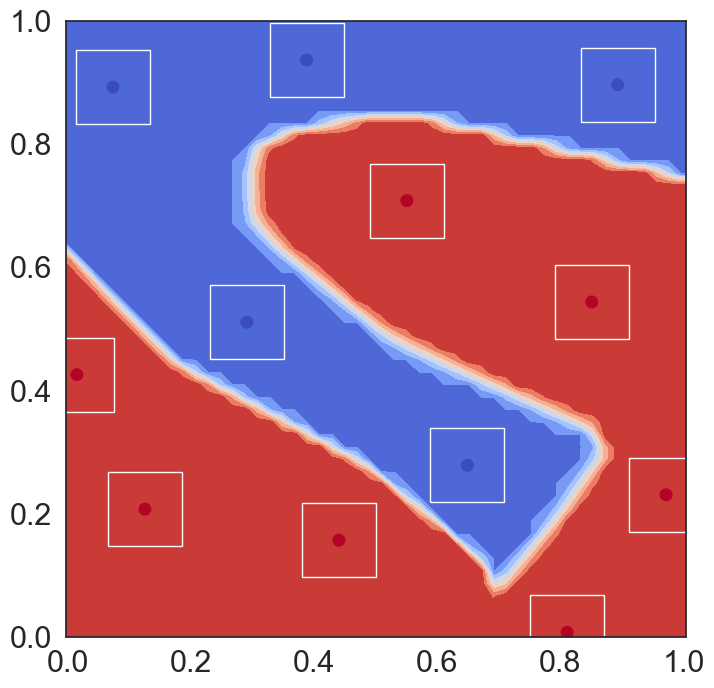

In [15]:
with torch.no_grad():
  XX, YY = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
  X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
  eps_temp = 0
  eps0 = eps_temp*torch.ones_like(X0)

  s1, s2, y0, s3 = net_with_eps(net3, Variable(X0), Variable(eps0))

  y0 = custom_activation(y0)
  ZZ = (y0).resize(100,100).data.numpy()
  fig, ax = plt.subplots(figsize=(8,8))
  ax.contourf(XX,YY,ZZ,  cmap="coolwarm")
  ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
  ax.axis("equal")
  ax.axis([-0,1,-0,1])

  for a in x:
      ax.add_patch(patches.Rectangle((a[0]-epsilon, a[1]-epsilon), 2*epsilon, 2*epsilon, fill=False))